# PopulationSim validation script

This notebook helps visualize and summarize the results of a PopulationSim model run.

## Inputs

This script uses several core input/output files from PopulationSim. A `.yaml` configuration helper file allows the user of this notebook to pick and choose which summaries to calculate. This configuration file can be rewritten to handle different regions without the need to rewite the script itself. The example file provided here is for the Corvallis-Albany-Lebanon Modeling (CALM) region in Oregon.

### config

In [1]:
region_yaml = 'melbourne.yaml'  # default

It contains several model-specific parameters:

- `popsim_dir:` the path to the main model run, containing popsim's data/output files,
- `scenario:` and `region:` for labeling output plots
- `summaries:` the list of `summary_*.csv` output files to use for validation
- `aggregate_summaries:` a list of desired control vs. results comparison columns to calculate from the summary files

See the example `region_yaml` for more.

### CSV file (optional)

Additional inputs parameters may be given via CSV.

E.x.
- POPSIMDIR
- VALID_DIR

Both input files may either be given directly in the notebook below, or on the command line (download the script by choosing `File` > `Download as` > `Python (.py)`):

```script
python validation.py calm_verification.yaml [parameters.csv]
```

## Outputs

- A CSV summary of statistics for each control group in `aggregate_summaries`
- A plot of the frequency distribution for each control group
- A plot of the standard deviation for each control group
- A CSV summary of aggregated statistics for a given geography (e.g. "PUMA")
- A plot of the household expansion factor distribution for the given geography

Requests for further outputs options and configurations are welcome via GitHub!

## Import packages

Required packages. The notebook requires `jupyter`, while the script needs only the following.

In [2]:
import os
import sys
try:
    import yaml
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError:
    packages = 'pyyaml pandas numpy matplotlib'
    ret = os.system(f'conda install {packages}')
    if ret != 0:
        os.system(f'{sys.executable} -m pip install {packages}')

## Configure matplotlib

In [3]:
%matplotlib inline
from matplotlib import cycler
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.prop_cycle'] = cycler(color=['b', 'g', 'r', 'y'])
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.constrained_layout.h_pad'] = 0.5
plt.rcParams['figure.figsize'] = (8,15)
plt.rcParams['hist.bins'] = 25

## Load input parameters

Read in the input file(s). If you encounter errors at this stage, be sure that
1. the paths to the files are correct
2. the YAML is well-structured (fields can't contain special characters like ':')

In [4]:
parameters = {}

# ignore sys.argv if running validation notebook
is_script = 'ipykernel' not in sys.modules

if is_script and len(sys.argv) > 1:
    if os.path.isfile(sys.argv[1]):
        region_yaml = sys.argv[1]

with open(region_yaml) as f:
    parameters.update(yaml.safe_load(f))

if is_script and len(sys.argv) > 2:
    if os.path.isfile(sys.argv[2]):
        parameters_csv = sys.argv[2]
        parameters.update(pd.read_csv(parameters_csv, header=None, index_col=0, comment='#').to_dict()[1])

In [5]:
print(yaml.dump(parameters))

aggregate_summaries:
- control: num_hh_control
  geography: SA1
  name: Total Households
  result: num_hh_result
- control: hh_size_1_control
  geography: SA1
  name: 'Household Size: 1 person HH'
  result: hh_size_1_result
- control: hh_size_2_control
  geography: SA1
  name: 'Household Size: 2 person HH'
  result: hh_size_2_result
- control: hh_size_3_control
  geography: SA1
  name: 'Household Size: 3 person HH'
  result: hh_size_3_result
- control: hh_size_4_control
  geography: SA1
  name: 'Household Size: 4 person HH'
  result: hh_size_4_result
- control: hh_size_5_control
  geography: SA1
  name: 'Household Size: 5 person HH'
  result: hh_size_5_result
- control: hh_size_6_plus_control
  geography: SA1
  name: 'Household Size: 6 plus person HH'
  result: hh_size_6_plus_result
- control: persons_work_full_control
  geography: SA2
  name: Work Fulltime
  result: persons_work_full_result
- control: persons_work_pt_control
  geography: SA2
  name: Work Parttime
  result: persons_wor

The `parameters` var contains all the input information needed for the validation script. Values may be updated either in the source files (recommended), or here in the notebook by updating keys of interest.

In [6]:
popsim_dir      = parameters.get('POPSIMDIR') or parameters.get('popsim_dir')
validation_dir  = parameters.get('VALID_DIR') or parameters.get('validation_dir')
geography_file  = parameters.get('geographies')
use_geographies = parameters.get('group_geographies')
summary_files   = parameters.get('summaries', [])
aggregate_list  = parameters.get('aggregate_summaries', [])
scenario        = parameters.get('scenario')
region          = parameters.get('region')
exp_hh_file     = parameters.get('expanded_hhid')
exp_hh_id_col   = parameters.get('expanded_hhid_col')
seed_hh_file    = parameters.get('seed_households')
seed_hh_cols    = parameters.get('seed_cols')

if not os.path.isdir(validation_dir):
    os.mkdir(validation_dir)

## Summaries
Create the master summary DataFrame from `parameters['summaries']`, listed either in the input YAML or above. 

In [7]:
summary_df = pd.DataFrame()
for summary_file in summary_files:
    filepath = os.path.join(popsim_dir, summary_file)
    df = pd.read_csv(filepath)
    summary_df = summary_df.append(df)

summary_df.head()

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_4080\2311733520.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(df)
C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_4080\2311733520.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(df)
C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_4080\2311733520.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(df)


,geography,id,num_hh_control,hh_size_1_control,hh_size_2_control,hh_size_3_control,hh_size_4_control,hh_size_5_control,hh_size_6_plus_control,persons_age_0_4_control,...,persons_sex_female_diff,persons_work_full_diff,persons_work_pt_diff,persons_work_casual_diff,persons_work_none_diff,hh_mv_0_diff,hh_mv_1_diff,hh_mv_2_diff,hh_mv_3_diff,hh_mv_4_plus_diff
0,SA3,20101.0,39081.0,11352.0,13271.0,5703.0,5523.0,2314.0,879.0,6772.0,...,-8510.0,18131.0,11961.0,1889.0,6146.0,-2172.0,-8992.0,-8191.0,-2416.0,-1271.0
1,SA3,20102.0,10593.0,3001.0,4027.0,1398.0,1252.0,656.0,277.0,1390.0,...,-5277.0,2641.0,2355.0,546.0,3300.0,-36.0,-2138.0,-751.0,-1065.0,-80.0
2,SA3,20103.0,10068.0,3282.0,3869.0,1205.0,1053.0,462.0,237.0,1194.0,...,-2264.0,5058.0,3540.0,653.0,1437.0,-339.0,-2493.0,-2660.0,-558.0,-150.0
3,SA3,20201.0,35554.0,10244.0,12338.0,5349.0,4659.0,2099.0,880.0,6192.0,...,-7707.0,16721.0,11061.0,1835.0,5207.0,-2386.0,-10543.0,-8777.0,-821.0,-972.0
4,SA3,20202.0,17579.0,4846.0,6601.0,2456.0,2383.0,996.0,340.0,2453.0,...,-4364.0,8134.0,6128.0,958.0,2466.0,-644.0,-3715.0,-5327.0,-1060.0,-227.0


In [8]:
summary_df.geography.unique()

array(['SA3', 'SA2', 'SA1'], dtype=object)

In [9]:
def process_geo_file(df):
    return df.rename(columns={'STATE_CODE_2016': 'State', 'SA3_CODE_2016': 'SA3', 'SA2_MAINCODE_2016': 'SA2', 'SA1_7DIGITCODE_2016': 'SA1'})

In [10]:
def meta_geog_df(summary_df, meta_geog):
    geography_df = pd.read_csv(os.path.join(popsim_dir, geography_file))
    geography_df = process_geo_file(geography_df)
    geog = use_geographies[use_geographies.index(meta_geog) + 1]  # next geography in list
    meta_df = geography_df[[meta_geog, geog]].drop_duplicates(ignore_index=True)
    geog_df = summary_df[summary_df.geography == geog].copy()
    geog_df['geography'] = meta_geog
    geog_df['id'] = geog_df.id.map(meta_df.set_index(geog).to_dict()[meta_geog])
    
    return geog_df
    
for geog in use_geographies:
    if not geog in summary_df.geography.unique():
        summary_df = summary_df.append(meta_geog_df(summary_df, geog))

summary_df.tail()

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_4080\449900070.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append(meta_geog_df(summary_df, geog))


,geography,id,num_hh_control,hh_size_1_control,hh_size_2_control,hh_size_3_control,hh_size_4_control,hh_size_5_control,hh_size_6_plus_control,persons_age_0_4_control,...,persons_sex_female_diff,persons_work_full_diff,persons_work_pt_diff,persons_work_casual_diff,persons_work_none_diff,hh_mv_0_diff,hh_mv_1_diff,hh_mv_2_diff,hh_mv_3_diff,hh_mv_4_plus_diff
38,State,2.0,13626.0,2843.0,4307.0,2453.0,2549.0,1105.0,419.0,2624.0,...,-2221.0,6953.0,3822.0,731.0,2183.0,-924.0,-2695.0,-3534.0,-958.0,-326.0
39,State,2.0,47383.0,7374.0,11552.0,8893.0,9829.0,5370.0,4196.0,13039.0,...,-12248.0,32080.0,17259.0,3654.0,12840.0,-714.0,-7404.0,-12206.0,-1924.0,-2341.0
40,State,2.0,53637.0,10831.0,16503.0,9902.0,10664.0,3998.0,1566.0,9000.0,...,-8247.0,28529.0,13319.0,3888.0,9008.0,-766.0,-6405.0,-7073.0,-4392.0,-2653.0
41,State,2.0,8243.0,1260.0,2458.0,1369.0,1953.0,959.0,280.0,1160.0,...,-1754.0,3893.0,2446.0,756.0,1741.0,-1189.0,-3026.0,-1363.0,-485.0,-23.0
42,State,2.0,39876.0,9615.0,12789.0,6658.0,6934.0,2772.0,1025.0,7259.0,...,-7338.0,19198.0,10536.0,1998.0,6390.0,-605.0,-5570.0,-10225.0,-2284.0,-1691.0


### Handle each control vs. result comparison specified in `parameters['aggregate_summaries']`.

In [11]:
def process_control(summary_df, name, geography, control, result):
    """
    Global
    ------
    summary_df: pandas DataFrame
    
    Parameters
    ----------
    name: str, output plot title
    geography: str, groupby geography
    control: str, control column name in summary table
    result: str, result column name in summary table
    
    Returns
    -------
    
    stats: pandas Series of statistics, aggregated by geography/control/result
    frequencies: pandas Series of control vs. results differences
    """

    sub_df = summary_df[summary_df.geography == geography][[control, result]].dropna(axis=0, how='any')
    
    observed = sub_df[control]
    non_zero_observed = observed[observed > 0]
    predicted = sub_df[result]
    difference = predicted - observed
    pc_difference = (difference/non_zero_observed)*100
    rmse = (difference ** 2).mean() ** 0.5
    
    frequencies = non_zero_observed.groupby(difference).count()

    stats = pd.Series({
        'name': name,
        'geography': geography,
        'observed': observed.sum(),
        'predicted': predicted.sum(),
        'difference': difference.sum(),
        'pc_difference': (difference.sum()/observed.sum())*100,
        'mean_pc_difference': pc_difference.mean(),
        'N': non_zero_observed.shape[0],
#         'rmse': rmse.sum(),
        'rmse': rmse,
        'std': pc_difference.std(),
    })

    return stats, frequencies, difference

### Plot each comparison and save outputs

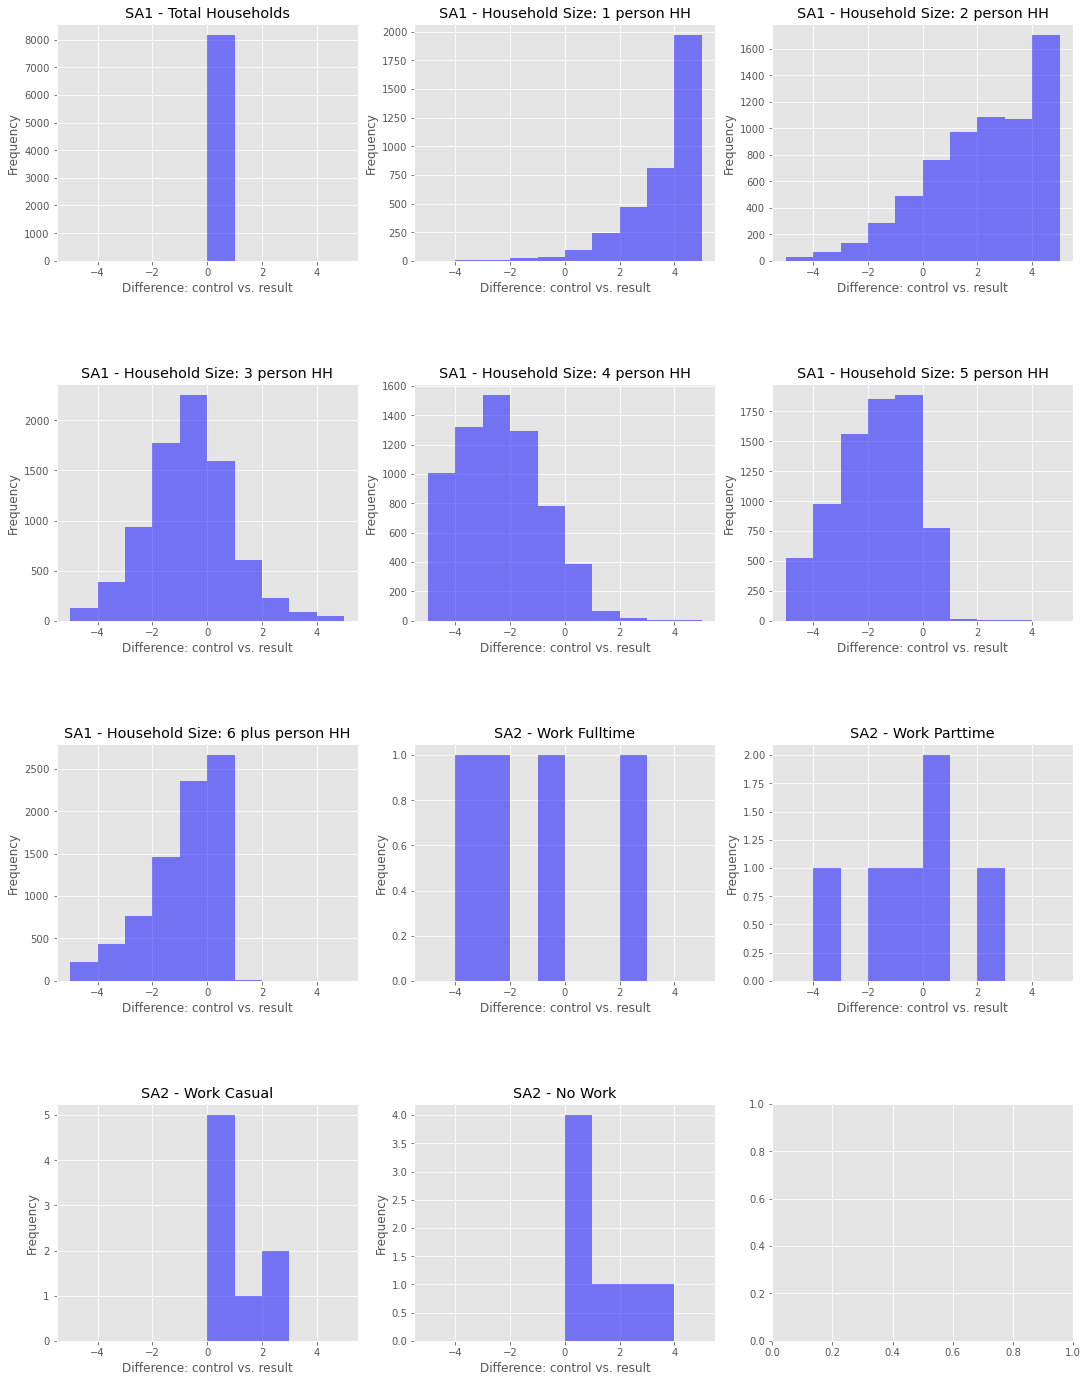

In [18]:
fig_w = 3
fig_l = int(len(aggregate_list) / fig_w) + 1

summary_fig, axes = plt.subplots(fig_l, fig_w, figsize=(fig_w * 5,fig_l*5))

stats = []
for params, ax in zip(aggregate_list, axes.ravel()):
    s, f, diff = process_control(summary_df, **params)
    stats.append(s)
    
    ax.set_title(f"{params['geography']} - {params['name']}")
    ax.set_ylabel('Frequency'); ax.set_xlabel('Difference: control vs. result')
    ax.hist(diff, bins=10, range=(-5,5), alpha=0.5)

summary_fig.savefig(os.path.join(validation_dir, 'frequencies.pdf'))
stats_df = pd.DataFrame(stats)
stats_df.to_csv(os.path.join(validation_dir, f'{scenario}_{region}_popsim_stats.csv'), index=False)

### Calculate the standard deviation for each comparison

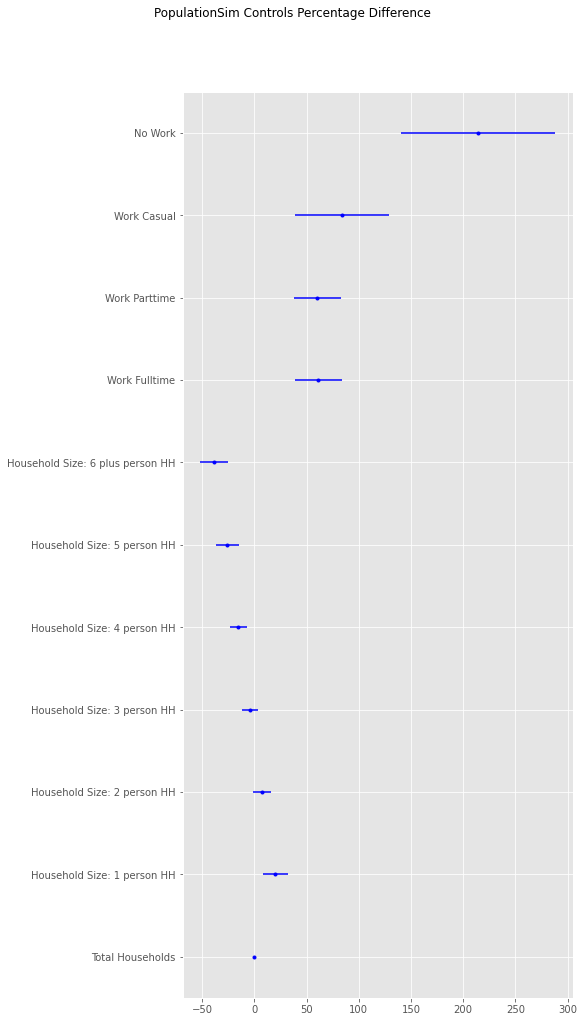

In [13]:
std_fig = plt.figure()
std_fig.suptitle('PopulationSim Controls Percentage Difference')
plt.errorbar(stats_df['mean_pc_difference'],
             stats_df['name'],
             xerr=stats_df['std'],
             linestyle='None',
             marker='.')

std_fig.savefig(os.path.join(validation_dir, f'{scenario}_{region}_popsim_convergence_stdev.pdf'))

## Uniformity

Examine the household weight distribution by geography using `expanded_hhid` and `seed_households`
```yaml
seed_cols:
    geog: SA3
    geog_weight: CW_ADHHWGT_SA3
    hh_id: hh_id
```

In [14]:
seed_cols = (seed_hh_cols.values())
geog = seed_hh_cols.get('geog')
geog_weight = seed_hh_cols.get('geog_weight')
hh_id = seed_hh_cols.get('hh_id')

expanded_hhids = pd.read_csv(os.path.join(popsim_dir, exp_hh_file), usecols=[exp_hh_id_col])
seed_hh_df = pd.read_csv(os.path.join(popsim_dir, seed_hh_file)).rename(columns={'HomeSA1': 'SA1', 'HomeSA2': 'SA2', 'HomeSA3': 'SA3','HomeSA4': 'SA4'})
seed_hh_df = seed_hh_df[seed_cols].set_index(hh_id)

Weight each household by its frequency in the household file, and by the given weight column. Group by geography and summarize.

In [15]:
weight_mask = seed_hh_df[geog_weight] > 0
weight = expanded_hhids[exp_hh_id_col].value_counts()[weight_mask]
expansion_factor = (weight/seed_hh_df[geog_weight]).fillna(0)

df = pd.DataFrame({
    geog: seed_hh_df[geog],
    geog_weight: seed_hh_df[geog_weight],
    'weight': weight,
    'ef': expansion_factor,
})

geog_group = df.groupby(geog)
geog_final_weight = geog_group.sum()['weight']
expansion = geog_final_weight/geog_group.sum()[geog_weight]

expansion.name = 'avg_expansion'
df = df.join(expansion, on=geog)
df['diff_sq'] = (df['avg_expansion'] - df['ef']) ** 2
rmse = df.groupby(geog).mean()['diff_sq'] ** 0.5

uniformity_df = pd.DataFrame({
    'W': geog_group.sum()[geog_weight],
    'Z': geog_group.sum()['weight'],
    'N': geog_group.count()[geog_weight],
    'EXP': expansion,
    'EXP_MIN': geog_group.min()['ef'],
    'EXP_MAX': geog_group.max()['ef'],
    'RMSE': rmse, 
})

uniformity_df.to_csv(os.path.join(validation_dir, 'uniformity.csv'))
print(uniformity_df.shape)
uniformity_df

(43, 7)


,W,Z,N,EXP,EXP_MIN,EXP_MAX,RMSE
SA3,,,,,,,
20101,48518.77,39081.0,572,0.805482,0.0,24.185541,2.210159
20102,5062.58,10593.0,31,2.092411,0.0,23.471650,5.025228
20103,38737.95,10068.0,395,0.259900,0.0,6.254559,0.638703
20201,66618.91,35554.0,734,0.533692,0.0,15.116503,1.139254
20202,62074.89,17579.0,497,0.283190,0.0,7.151143,0.825348
20203,36850.33,4392.0,355,0.119185,0.0,3.442868,0.297179
20301,28982.28,6309.0,228,0.217685,0.0,5.511811,0.681045
20302,30233.02,70257.0,334,2.323850,0.0,57.253660,6.294404
20303,22549.85,26022.0,211,1.153977,0.0,22.610394,3.557496


In [16]:
geogs = df[geog].unique()
geog_fig = plt.figure(figsize=(10*len(geogs), 10))
geog_fig.set_figheight(200)
geog_fig.set_figwidth(200)

for i, g in enumerate(geogs):
    geog_df = df[df[geog] == g]
    counts, bins = np.histogram(geog_df['ef'])
    ax = geog_fig.add_subplot(22, 2, i+1)
    ax.set_title(f'{geog} {g}')
    ax.set_ylabel('Percentage'); ax.set_xlabel('Expansion Factor Range')
    ax.hist(bins[:-1], bins, weights=counts*100/len(geog_df), alpha=0.6)
    ax.plot()